In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
# normalize and flatten later
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:11<00:00, 867kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 95.2kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 595kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.85MB/s]


In [4]:
# Split training set into train & validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

In [5]:
# data loader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
# model Aricitecture

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x)

In [7]:
model = MNISTClassifier()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train_model(model, train_loader, val_loader, epochs):
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images, labels
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        train_acc_list.append(train_accuracy)

        # model accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images, labels
                outputs = model(images)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = 100 * correct / total
        val_acc_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}]  Train Acc: {train_accuracy:.2f}%  Val Acc: {val_accuracy:.2f}%")
    return train_acc_list, val_acc_list


In [10]:
# train model

train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=15)

Epoch [1/15]  Train Acc: 91.42%  Val Acc: 96.60%
Epoch [2/15]  Train Acc: 95.49%  Val Acc: 97.20%
Epoch [3/15]  Train Acc: 96.24%  Val Acc: 97.27%
Epoch [4/15]  Train Acc: 96.89%  Val Acc: 97.53%
Epoch [5/15]  Train Acc: 97.23%  Val Acc: 97.78%
Epoch [6/15]  Train Acc: 97.51%  Val Acc: 98.05%
Epoch [7/15]  Train Acc: 97.68%  Val Acc: 98.02%
Epoch [8/15]  Train Acc: 97.89%  Val Acc: 98.08%
Epoch [9/15]  Train Acc: 97.99%  Val Acc: 98.02%
Epoch [10/15]  Train Acc: 98.20%  Val Acc: 97.85%
Epoch [11/15]  Train Acc: 98.23%  Val Acc: 98.05%
Epoch [12/15]  Train Acc: 98.46%  Val Acc: 98.20%
Epoch [13/15]  Train Acc: 98.53%  Val Acc: 98.23%
Epoch [14/15]  Train Acc: 98.60%  Val Acc: 98.17%
Epoch [15/15]  Train Acc: 98.56%  Val Acc: 98.43%


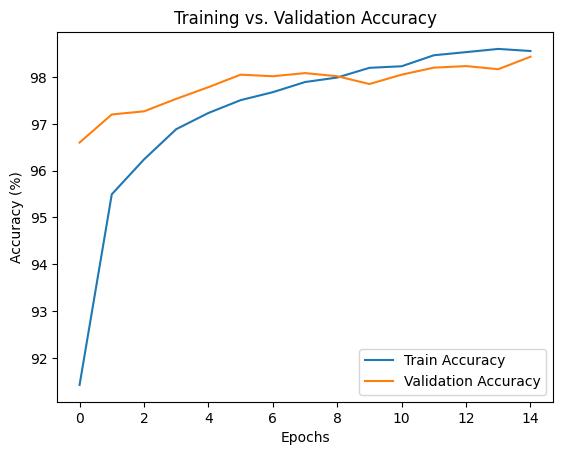

In [11]:
# Visualization

plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

In [12]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images, labels
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')

Final Test Accuracy: 98.43%


In [13]:
torch.save(model.state_dict(), 'model.pt')